<center>
<h1>Fake news detection using graph neural network</h1>
<h3>Learning From Networks A.Y. 2021/2022</h3>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import os
import torch
import numpy as np
import os.path as osp
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch_sparse import coalesce
from torch.nn import Linear, LogSoftmax
from torch_geometric.datasets import UPFD
from torch_geometric.io import read_txt_array
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import Data, InMemoryDataset
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, global_max_pool

In [2]:
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html

# Dataset

## Create dataset with new features

### Define tools class

In [3]:
class tool():

    # GRAPH
    def g_avg_dg(G):
        return np.mean([d for _, d in G.degree()])

    def g_std_dg(G):
        return np.std([d for _, d in G.degree()])

    def g_root_dg(G):
        return G.degree()[0]
    
    def g_root_cc(G):
        return nx.closeness_centrality(G, 0)
    
    def g_max_cc(G):
        return max(nx.closeness_centrality(G).values())
    
    def g_max_bc(G):
        return max(nx.betweenness_centrality(G).values())
        

    # NODE
    def n_cc(G):
        return list(nx.closeness_centrality(G).values())

    def n_bc(G):
        return list(nx.betweenness_centrality(G).values())
    
    def n_dg(G):
        return list(dict(G.degree()).values())

In [4]:
nodes_f = {n:f for n, f in tool.__dict__.items() if n[:2] == 'n_'}
graphs_f = {n:f for n, f in tool.__dict__.items() if n[:2] == 'g_'}

### Define the dataset class

In [5]:
class ext_UPFD(InMemoryDataset):

    ids = {
        'politifact': '1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-',
        'gossipcop': '1VskhAQ92PrT4sWEKQ2v2-AJhEcpp4A81',
    }

    def __init__(self, name, root, n_features=[], g_features=[], split="train", transform=None):
        
        self.name = name
        self.root = root
        self.source = 'gossipcop'
        self.raw_feature = 'profile'
        self.n_features = n_features
        self.g_features = g_features
        super().__init__(root, transform, None, None)

        assert split in ['train', 'val', 'test']
        path = self.processed_paths[['train', 'val', 'test'].index(split)]
        self.data, self.slices = torch.load(path)

    @property
    def raw_dir(self):
        return osp.join(self.root, self.source, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, self.source, 'processed', self.raw_feature)

    @property
    def raw_file_names(self):
        return [
            'node_graph_id.npy', 'graph_labels.npy', 'A.txt', 'train_idx.npy',
            'val_idx.npy', 'test_idx.npy', f'new_{self.raw_feature}_feature.npz'
        ]

    @property
    def processed_file_names(self):
        return [f'train_{self.name}.pt', 
                f'val_{self.name}.pt', 
                f'test_{self.name}.pt']

    def download(self):
        gdd.download_file_from_google_drive(
            self.ids[self.source], osp.join(self.raw_dir, f'{self.source}.zip'),
            unzip=True)
        os.remove(osp.join(self.raw_dir, f'{self.source}.zip'))
    
    def get_n_features(self, G):
        # We have to calculate the new features for each node in the matrix x
        n_features = []

        for ft, fct in nodes_f.items():
            ft_i = []
            if ft in self.n_features:
                for g in G:
                    ft_i += fct(g)
                n_features.append(ft_i)
        n_features = np.transpose(np.asarray(n_features))
        return torch.Tensor(n_features)
    
    def get_g_features(self, G):
        # for each graph we have to compute the graph features
        g_features = []

        for ft, fct in graphs_f.items():
            ft_i = []
            if ft in self.g_features:
                for g in G:
                    ft_i.append(fct(g))
                g_features.append(ft_i)
        g_features = np.asarray(g_features)
        return torch.Tensor(g_features)
    
    def add_new_features(self, x, y):
        
        G = [to_networkx(x) for x in self]
        
        new_n_features = self.get_n_features(G)
        x_new = x.type(torch.float32) if len(new_n_features) == 0 else torch.concat([x, new_n_features], axis=1)
        
        new_g_features = self.get_g_features(G)
        y_new = y.reshape(-1, 1).type(torch.float32) if len(new_g_features) == 0 else torch.t(torch.vstack([y, new_g_features]))
        
        changed = len(new_n_features) != 0 or len(new_g_features) != 0
        return x_new, y_new, changed

    def process(self):
        
        # Download raw data
        x, y, batch, edge_index = self.load_raw()
        
        # Set the slices for the nodes
        node_slice = self.set_slices(batch, edge_index, y)
        edge_index -= node_slice[batch[edge_index[0]]].view(1, -1)
        
        # Initiate the graph dataset
        self.data = Data(x=x, edge_index=edge_index, y=y)
        
        # Compute new features and add them
        x_new, y_new, changed = self.add_new_features(x, y)
        self.data = Data(x=x_new, edge_index=edge_index, y=y_new) 
        
        
        # Actualize the graph dataset
        for path, split in zip(self.processed_paths, ['train', 'val', 'test']):
            idx = np.load(osp.join(self.raw_dir, f'{split}_idx.npy')).tolist()
            
            n_g_id = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
            data_list = []

            for i in idx:
            
                graph = self.get(i)
                x_idx = np.argwhere(n_g_id == i).flatten()
                x_feat = x_new[x_idx, :]
                y_feat = torch.unsqueeze(y_new[i, :], 0)

                datum = Data(x=x_feat, edge_index=graph.edge_index, y=y_feat)
                data_list.append(datum)
        
            torch.save(self.collate(data_list), path)
            
    def load_raw(self):
        
        x = sp.load_npz(
            osp.join(self.raw_dir, f'new_{self.raw_feature}_feature.npz'))
        x = torch.from_numpy(x.todense()).to(torch.float)

        edge_index = read_txt_array(osp.join(self.raw_dir, 'A.txt'), sep=',',
                                    dtype=torch.long).t()
        edge_index, _ = coalesce(edge_index, None, x.size(0), x.size(0))

        y = np.load(osp.join(self.raw_dir, 'graph_labels.npy'))
        y = torch.from_numpy(y).to(torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

        batch = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
        batch = torch.from_numpy(batch).to(torch.long)
        
        return x, y, batch, edge_index

    def set_slices(self, batch, edge_index, y):
        
        node_slice = torch.cumsum(batch.bincount(), 0)
        node_slice = torch.cat([torch.tensor([0]), node_slice])
        edge_slice = torch.cumsum(batch[edge_index[0]].bincount(), 0)
        edge_slice = torch.cat([torch.tensor([0]), edge_slice])
        graph_slice = torch.arange(y.size(0) + 1)
        self.slices = {
            'x': node_slice,
            'edge_index': edge_slice,
            'y': graph_slice
        }
        return node_slice

    def __repr__(self):
        return (f'{self.__class__.__name__}({len(self)}, name={self.source}, '
                f'raw_feature={self.raw_feature}, node feature={self.n_features}, '
                f'graph feature={self.g_features})')

### Import data

In [6]:
path = './data/'

In [7]:
origin_train = ext_UPFD('original', path, split='train')
origin_val = ext_UPFD('original', path, split='val')
origin_test = ext_UPFD('original', path, split='test')

In [8]:
n_ft = ['n_dg', 'n_cc']
g_ft = ['g_avg_dg', 'g_root_dg']
data1_train = ext_UPFD('data1', path, n_ft, g_ft, split='train')
data1_val = ext_UPFD('data1', path, n_ft, g_ft, split='val')
data1_test = ext_UPFD('data1', path, n_ft, g_ft, split='test')

In [9]:
n_ft = ['n_dg', 'n_cc', 'n_bc']
g_ft = ['g_avg_dg', 'g_std_dg', 'g_root_dg', 'g_root_cc', 'g_max_cc', 'g_max_bc']

data2_train = ext_UPFD('data2', path, n_ft, g_ft, split='train')
data2_val = ext_UPFD('data2', path, n_ft, g_ft, split='val')
data2_test = ext_UPFD('data2', path, n_ft, g_ft, split='test')

In [10]:
datasets = [('origin', origin_train, origin_val, origin_test),
            ('dataset1', data1_train, data1_val, data1_test),
            ('dataset2', data2_train, data2_val, data2_test)]

## Show data

In [11]:
def plot_minigraph(n, dataset):

    nx_g = {'true':[], 'false':[]}
    for x in dataset:
        if x.y[0, 0]:
            nx_g['true'] += [to_networkx(x)]
        else:
            nx_g['false'] += [to_networkx(x)]

    
    for k in range(n):
        col1 = [1] + [0 for _ in range(len(nx_g['true'][k].nodes)-1)]
        col2 = [1] + [0 for _ in range(len(nx_g['false'][k].nodes)-1)]

        plt.figure(1, figsize=(16, 8)) 
        plt.subplot(1, 2, 1)
        nx.draw(nx_g['true'][k], node_size=75, linewidths=6, node_color=col1)
        plt.subplot(1, 2, 2)
        nx.draw(nx_g['false'][k], node_size=75, linewidths=6, node_color=col2)
        plt.show()

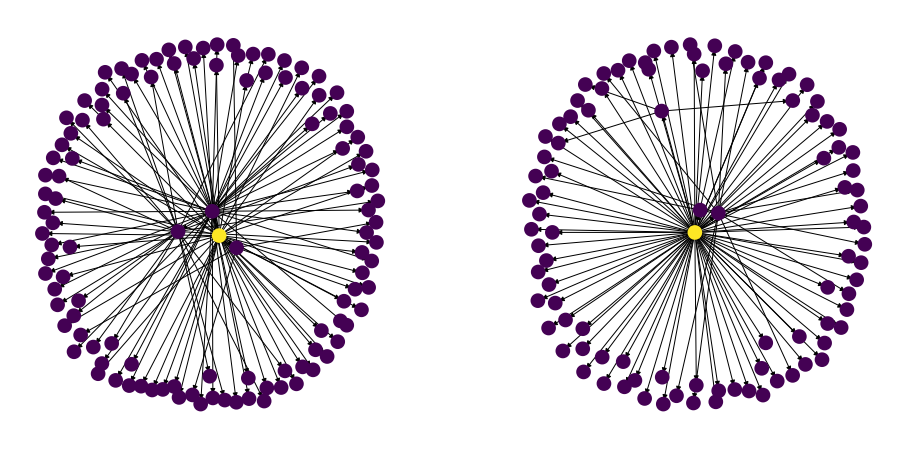

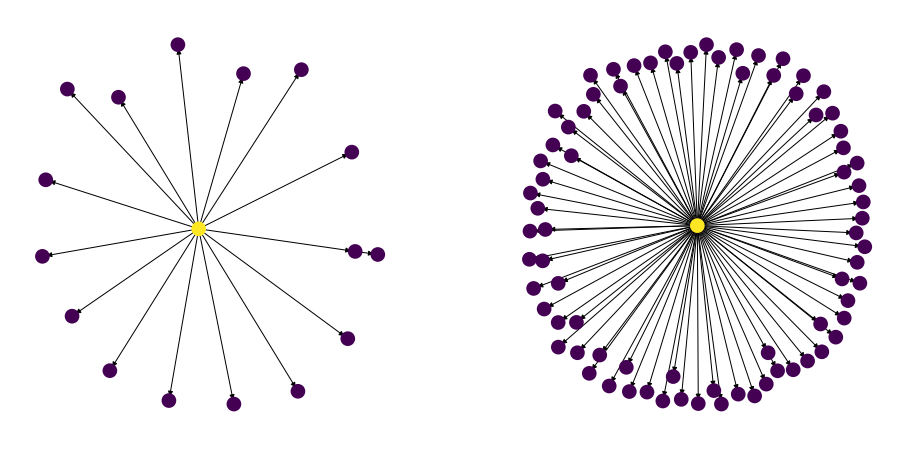

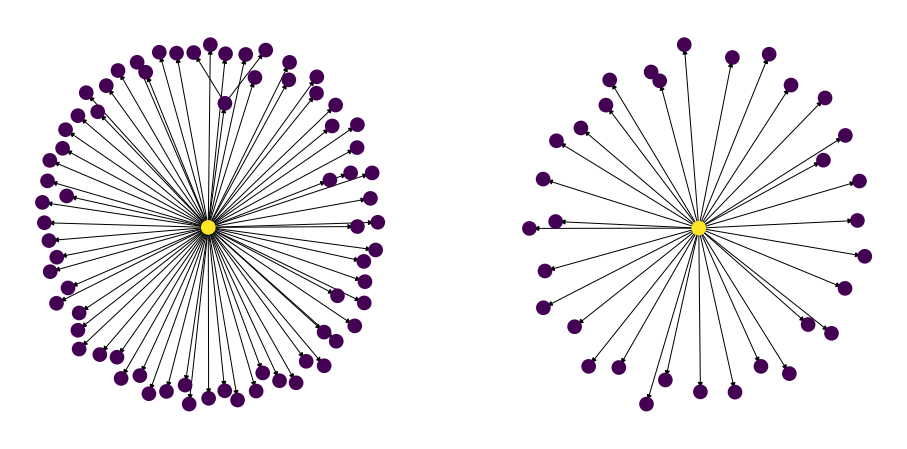

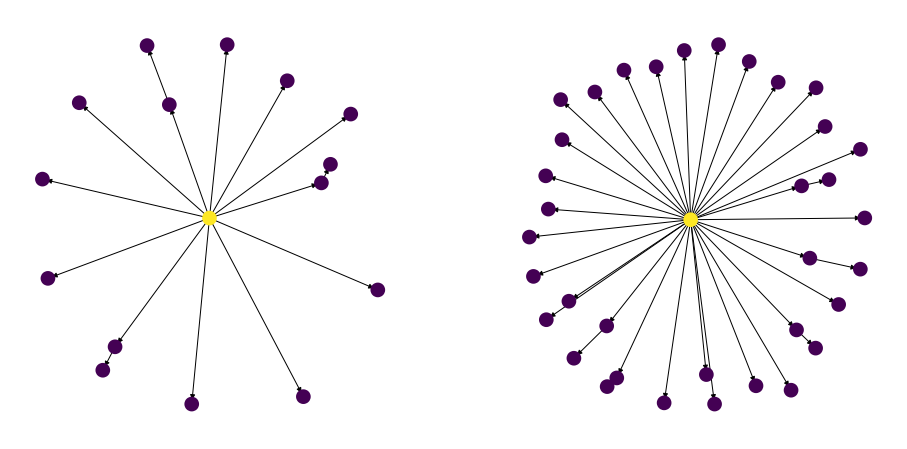

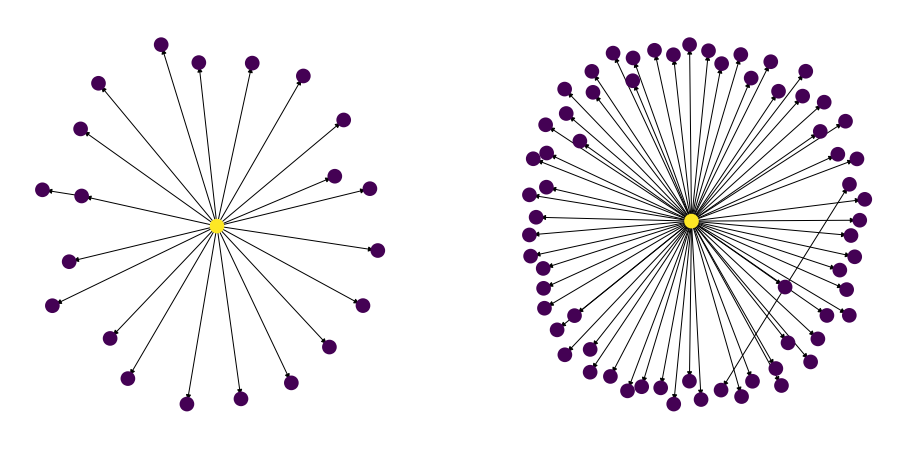

In [12]:
plot_minigraph(5, data2_test)

# Define some models

Here we will define some model, from basic to more elaborate ones.

## Simple GNN

In [13]:
class GNN(torch.nn.Module):

    def __init__(self, num_n_feature, num_g_feature, emb_size):
        super(GNN, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size

        self.in_layer = GCNConv(num_n_feature, emb_size)
        self.conv = GCNConv(emb_size, emb_size)
       
       # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)
    
    def forward(self, x, edges_idx, batch_idx, g_features):
        
        x = self.in_layer(x, edges_idx)
        x = self.conv(x, edges_idx)

        flatten = torch.cat([global_mean_pool(x, batch_idx),
                             global_max_pool(x, batch_idx)], axis=1)

        if g_features.size()[-1]:
            g_ft = self.lin_g(g_features)
            flatten = torch.cat([flatten, g_ft], axis=1)

        out = self.act(self.out_layer(flatten))

        return out


## More advanced model (to do)

# Train models

We can now train our models each on our differents datasets. Then we will be able to compare the performance of the models on the differents dataset and conclude if new features improve in average the results

## Define training

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f"Training Device: {device}")

Training Device: cuda


In [15]:
def get_acc(y_pred, y_real):
    y_pred = y_pred.argmax(dim=-1)
    correct = int((y_pred == y_real).sum())
    return correct / len(y_real)

In [16]:
def train_step(model, data, optimizer, loss_f):
    model.train()
    tot_loss, acc = 0, 0
    for batch in data:
        batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch, batch.y[:, 1:])
        y_real = batch.y[:, 0].type(torch.int64)
        
        acc += get_acc(out, y_real)
        loss = loss_f(out, y_real) 
        tot_loss += loss.item()

        loss.backward()
        optimizer.step()

    return round(tot_loss/len(data), 2), round(acc/len(data), 2)

In [17]:
@torch.no_grad()
def val_step(model, data, loss_f):
    model.eval()
    tot_loss, acc = 0, 0
    for batch in data:
        batch.to(device)
        
        out = model(batch.x, batch.edge_index, batch.batch, batch.y[:, 1:])
        y_real = batch.y[:, 0].type(torch.int64)

        acc += get_acc(out, y_real)
        tot_loss += loss_f(out, y_real).item()
    return round(tot_loss/len(data), 2), round(acc/len(data), 2)

In [18]:
def train(model, data_train, data_val, epochs=100):
    acc_losses_t, acc_losses_v = [], []
    loss_f = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

    train_loader = DataLoader(data_train, batch_size=128, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=128, shuffle=True)

    for epoch in tqdm(range(epochs)):
        loss_t, acc_t = train_step(model, train_loader, optimizer, loss_f)
        loss_v, acc_v = val_step(model, val_loader, loss_f)
        
        acc_losses_t.append([loss_t, acc_t])
        acc_losses_v.append([loss_v, acc_v])
        if (epoch+1) % 10 == 0:
            print(f'Epochs: {epoch+1} | loss_train={loss_t}  loss_val={loss_v} | acc_train={acc_t}  acc_val={acc_v}')
    return acc_losses_t, acc_losses_v

In [19]:
def plot_hist(hists):

    labels = ['Loss', 'Accuracy']
    accs = []
    for hist in hists:
        title, _, hist = hist
        acc_losses_t, acc_losses_v = np.asarray(hist[0]), np.asarray(hist[1])
        accs.append([title, acc_losses_v[:, 1]])
        fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
        fig.suptitle(f'Dataset: {title}', fontsize=16)
        for i, l in enumerate(labels):
            axs[i].plot(acc_losses_t[:, i], label=f'{l} train')
            axs[i].plot(acc_losses_v[:, i], '--', label=f'{l} val')
            axs[i].set_title(f'{l} evolution')
            axs[i].set_xlabel('Epochs')
            axs[i].set_ylabel(l)
            axs[i].grid()
            axs[i].legend()
        plt.show()

    plt.figure(figsize=(10, 5))
    plt.title('Comparison of the accuracy on each dataset')
    for x in accs:
        plt.plot(x[1], label=x[0])
    plt.legend()
    plt.grid()
    plt.show()

## Simple GNN train

In [20]:
models = []
for x in datasets:
    print(f'--> Train on: {x[0]}')
    model = GNN(x[1].num_features, len(x[1].g_features), 100).to(device)
    hist = train(model, x[1], x[2], epochs=100)
    models.append([x[0], model, hist])

--> Train on: origin


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.51  loss_val=0.5 | acc_train=0.79  acc_val=0.79
Epochs: 20 | loss_train=0.44  loss_val=0.43 | acc_train=0.82  acc_val=0.8
Epochs: 30 | loss_train=0.42  loss_val=0.41 | acc_train=0.82  acc_val=0.84
Epochs: 40 | loss_train=0.42  loss_val=0.42 | acc_train=0.83  acc_val=0.82
Epochs: 50 | loss_train=0.41  loss_val=0.39 | acc_train=0.84  acc_val=0.84
Epochs: 60 | loss_train=0.41  loss_val=0.4 | acc_train=0.83  acc_val=0.85
Epochs: 70 | loss_train=0.4  loss_val=0.37 | acc_train=0.83  acc_val=0.85
Epochs: 80 | loss_train=0.39  loss_val=0.38 | acc_train=0.85  acc_val=0.86
Epochs: 90 | loss_train=0.38  loss_val=0.38 | acc_train=0.85  acc_val=0.84
Epochs: 100 | loss_train=0.37  loss_val=0.37 | acc_train=0.85  acc_val=0.86
--> Train on: dataset1


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.54  loss_val=0.53 | acc_train=0.78  acc_val=0.72
Epochs: 20 | loss_train=0.5  loss_val=0.53 | acc_train=0.78  acc_val=0.82
Epochs: 30 | loss_train=0.52  loss_val=0.52 | acc_train=0.77  acc_val=0.73
Epochs: 40 | loss_train=0.55  loss_val=0.49 | acc_train=0.78  acc_val=0.82
Epochs: 50 | loss_train=0.51  loss_val=0.52 | acc_train=0.78  acc_val=0.81
Epochs: 60 | loss_train=0.51  loss_val=0.5 | acc_train=0.77  acc_val=0.8
Epochs: 70 | loss_train=0.51  loss_val=0.57 | acc_train=0.77  acc_val=0.7
Epochs: 80 | loss_train=0.48  loss_val=0.48 | acc_train=0.79  acc_val=0.78
Epochs: 90 | loss_train=0.47  loss_val=0.49 | acc_train=0.79  acc_val=0.81
Epochs: 100 | loss_train=0.47  loss_val=0.5 | acc_train=0.78  acc_val=0.78
--> Train on: dataset2


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.59  loss_val=0.56 | acc_train=0.76  acc_val=0.72
Epochs: 20 | loss_train=0.54  loss_val=0.56 | acc_train=0.78  acc_val=0.7
Epochs: 30 | loss_train=0.52  loss_val=0.55 | acc_train=0.79  acc_val=0.71
Epochs: 40 | loss_train=0.49  loss_val=0.5 | acc_train=0.8  acc_val=0.81
Epochs: 50 | loss_train=0.47  loss_val=0.47 | acc_train=0.8  acc_val=0.78
Epochs: 60 | loss_train=0.46  loss_val=0.47 | acc_train=0.81  acc_val=0.81
Epochs: 70 | loss_train=0.46  loss_val=0.46 | acc_train=0.79  acc_val=0.76
Epochs: 80 | loss_train=0.45  loss_val=0.47 | acc_train=0.81  acc_val=0.83
Epochs: 90 | loss_train=0.48  loss_val=0.46 | acc_train=0.8  acc_val=0.81
Epochs: 100 | loss_train=0.47  loss_val=0.44 | acc_train=0.79  acc_val=0.82


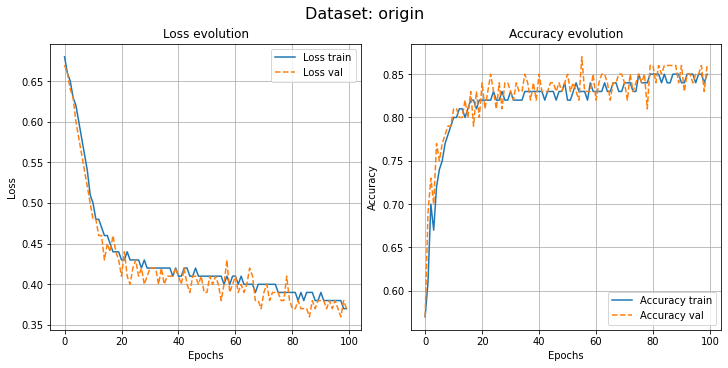

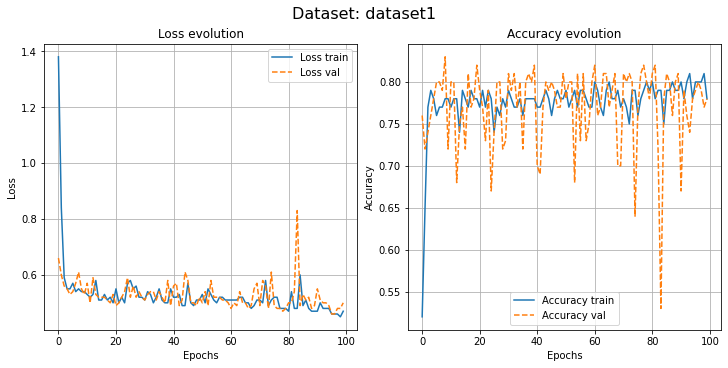

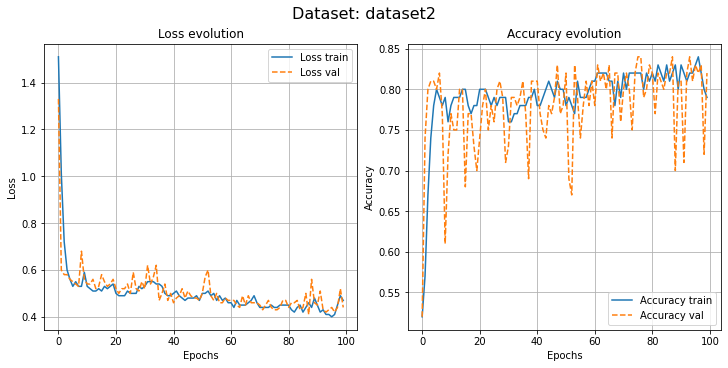

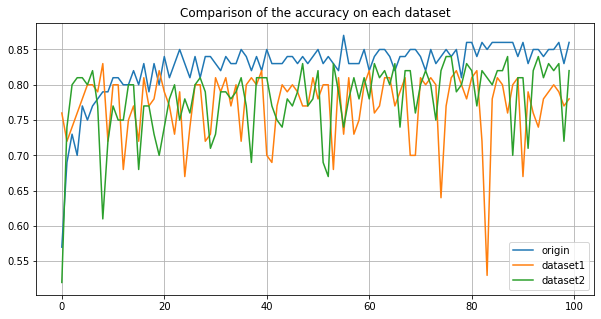

In [21]:
plot_hist(models)

## More advanced model training (to do)